In [24]:
from desc.objectives import ParticleTracer
from desc.grid import Grid
import desc.io
from desc.backend import jnp
import scipy.constants

In [25]:
eq = desc.io.load("input.final_freeb_output.h5")[-1]
eq._iota = eq.get_profile("iota").to_powerseries(order=eq.L, sym=True)
eq._current = None
# eq.solve()

In [26]:
# Energy and Mass info
Energy_eV = 1
Proton_Mass = scipy.constants.proton_mass
Proton_Charge = scipy.constants.elementary_charge

Energy_SI = Energy_eV*Proton_Charge

# Particle Info
Mass = 4*Proton_Mass
Charge = 2*Proton_Charge

# Initial State
psi_i = 0.3
zeta_i = 0
theta_i = 0
vpar_i = 0.7*jnp.sqrt(2*Energy_SI/Mass)
ini_cond = [float(psi_i), theta_i, zeta_i, float(vpar_i)]

# Time
tmin = 0
tmax = 0.01
nt = 2000
time = jnp.linspace(tmin, tmax, nt)

initial_conditions = ini_cond
Mass_Charge_Ratio = Mass/Charge

In [27]:
print(vpar_i)

4844.392761952927


In [28]:
grid = Grid(jnp.array([jnp.sqrt(psi_i), theta_i, zeta_i]).T, jitable=True, sort=False)
data = eq.compute("|B|", grid=grid)

mu = Energy_SI/(Mass*data["|B|"]) - (vpar_i**2)/(2*data["|B|"])

ini_param = [float(mu), Mass_Charge_Ratio]

objective = ParticleTracer(eq=eq, output_time=time, initial_conditions=ini_cond, initial_parameters=ini_param, compute_option="tracer")


In [29]:
print(data["|B|"])
print(mu)

[0.96427144]
[12665533.56174116]


In [30]:
objective.build()
solution = objective.compute(*objective.xs(eq))

2023-09-29 10:26:47.217231: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-09-29 10:28:55.132321: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m7.933224218s

********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [31]:
def output_to_file(solution, name):
    list1 = solution[:, 0]
    list2 = solution[:, 1]
    list3 = solution[:, 2]
    list4 = solution[:, 3]

    combined_lists = zip(list1, list2, list3, list4)
    
    file_name = f'{name}.txt'

    with open(file_name, 'w') as file:        
        for row in combined_lists:
            row_str = '\t'.join(map(str, row))
            file.write(row_str + '\n')

output_to_file(solution=solution, name="comparison_output")

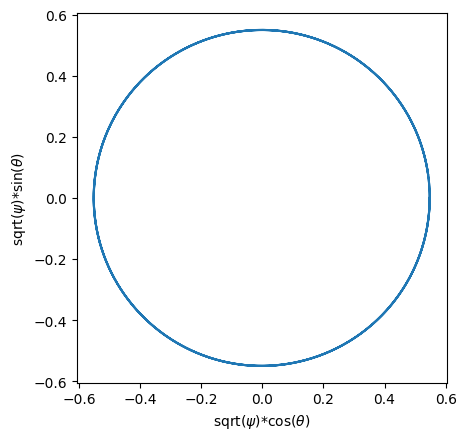

In [32]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

#create simple line plot

ax.plot(np.sqrt(solution[:, 0]) * np.cos(solution[:, 1]), np.sqrt(solution[:, 0]) * np.sin(solution[:, 1]))

#set aspect ratio to 1
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect("equal", adjustable='box')

plt.xlabel(r'sqrt($\psi$)*cos($\theta$)')
plt.ylabel(r'sqrt($\psi$)*sin($\theta$)')
plt.show()

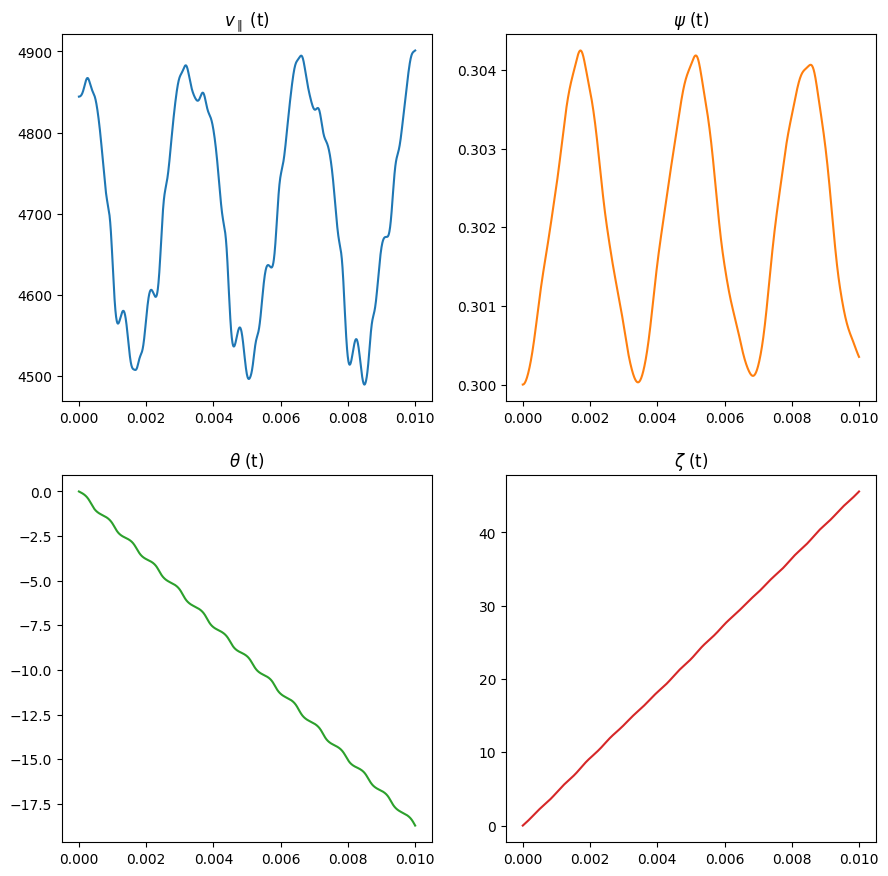

In [33]:
fig, axs = plt.subplots(2, 2)
axs[0, 1].plot(time, solution[:, 0], 'tab:orange')
axs[0, 1].set_title(r'$\psi$ (t)')
axs[1, 0].plot(time, solution[:, 1], 'tab:green')
axs[1, 0].set_title(r'$\theta$ (t)')
axs[1, 1].plot(time, solution[:, 2], 'tab:red')
axs[1, 1].set_title(r'$\zeta$ (t)')
axs[0, 0].plot(time, solution[:, 3], 'tab:blue')
axs[0, 0].set_title(r"$v_{\parallel}$ (t)")

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

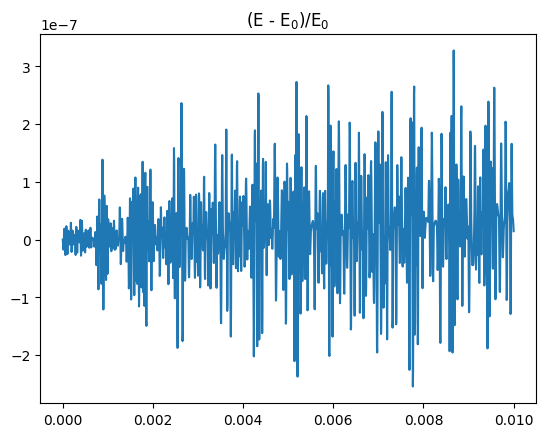

In [36]:
grid = Grid(np.vstack((np.sqrt(solution[:, 0]), solution[:, 1], solution[:, 2])).T,sort=False)
B_field = eq.compute("|B|", grid=grid)
Energy = 0.5*(solution[:, 3]**2 + 2*B_field["|B|"]*mu)*Mass

plt.plot(time, (Energy-Energy_SI)/Energy_SI)
plt.title(r"(E - E$_0$)/E$_0$")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))